# Distribution of the lengths of the protein coding genes 
**for the different species**

## Import python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os 
import pandas as pd
import math

# BASE_PATH
system = list(os.uname())[0]
if system == 'Linux':
    BASE_PATH = "/media/emuro/Nubya/"
elif system == 'Darwin':
    BASE_PATH = "/Volumes/Nubya/"  # or Wes; BIRD
LENofGENES_BASE_PATH = BASE_PATH + "results/geneLength/"

STAT_FILE_SPECIES_PATH = "../../../main_tables/"
ENSEMBL_TAXID_PATH = STAT_FILE_SPECIES_PATH + "extra_tables/"
GO_PATH = "/home/emuro/Desktop/peak_receptors/ensembl_annotation__cavia_porcellus/biomart/"

## The protein coding gene length distributions for the different species

### Retrieving the statistical descriptions of the gene length's distributions and the taxonomy ids

#### Statistical description 

In [2]:
# statistics on length distribution for different species     
stat_file = STAT_FILE_SPECIES_PATH + "stat_protCodGenes.tsv"
print("The statistical descriptions of the protein coding gene distributions for the different species is in:\n", stat_file, "\n")

# retrieve data and diminish the number of columns
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["division_8", "species", "trunk_genes_path", "genes_file", "count", "mean", "var"] + ["log10_mean", "log10_var"]]

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(stat_df.head(2))
    print(stat_df.shape)

The statistical descriptions of the protein coding gene distributions for the different species is in:
 ../../../main_tables/stat_protCodGenes.tsv 



,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var
0,archaea,methanobacterium_bryantii_gca_002287175,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.methanobacterium_bryantii...,3168,840.404040,422343.848699,2.827684,0.082694
1,archaea,methanobacterium_formicicum_gca_000762265,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.methanobacterium_formicic...,2352,862.427296,347239.612747,2.849723,0.076317


(33627, 9)


#### Taxonomy id for each species from Ensembl

In [3]:
# ENSEMBL tax_id     
ensembl_taxId_file = ENSEMBL_TAXID_PATH + "species_Ensembl.tsv" 

# retrieve data
taxid_df = pd.read_csv(ensembl_taxId_file, sep="\t")
taxid_df = taxid_df[["#name", "species", "taxonomy_id"]]
taxid_df.rename(columns = {"#name" : 'name', "taxonomy_id" : 'tax_id'}, inplace = True)

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(taxid_df.head(2))
    print(taxid_df.shape)

,name,species,tax_id
0,Spiny chromis,acanthochromis_polyacanthus,80966
1,Panda,ailuropoda_melanoleuca,9646


(33021, 3)


In [4]:
# Use pandas.merge() on multiple columns
stat_taxid_df = pd.merge(stat_df, taxid_df, on=['species'])
#stat_taxid_df = stat_taxid_df[stat_taxid_df['tax_id'].notna()]
if 1:
    display(stat_taxid_df.head(2))
    print(stat_taxid_df.shape)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    print(stat_taxid_df['tax_id'].describe())
    if 1: # no need
        stat_taxid_df = stat_taxid_df[stat_taxid_df['tax_id'].notna()]
        print(stat_taxid_df.shape)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
0,archaea,methanobacterium_bryantii_gca_002287175,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.methanobacterium_bryantii...,3168,840.404040,422343.848699,2.827684,0.082694,Methanobacterium bryantii str. M.o.H. (GCA_002...,2161
1,archaea,methanobacterium_formicicum_gca_000762265,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.methanobacterium_formicic...,2352,862.427296,347239.612747,2.849723,0.076317,Methanobacterium formicicum str. BRM9 (GCA_000...,2162


(33630, 11)
count     33630.00000
mean     907971.98052
std      846961.42748
min          23.00000
25%       33888.25000
50%      696032.00000
75%     1750203.25000
max     2676064.00000
Name: tax_id, dtype: float64
(33630, 11)


## Python functions

In [5]:
# species' stats for length distribution
def get_df_for_taxid(df, taxid):
     return df.loc[df["tax_id"]==taxid].copy()

#### [Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)
It is a continuous probability distribution of a random variable whose logarithm is normally distributed. For human-readability the decimal logarithm (log10) is used.
  
**The PDF (Probability Density Function) of a normal distribution is**  
$ f(x) = \frac{1}{ \sigma \sqrt{2 \pi}} e^- \frac{1}{2} {(\frac{(x-\mu)}{\sigma})}^{2} $

In [6]:
#### Function to plot the log-normal distribution
# blue: Observation
# red: Theoretical/Simulation
##########################################
def plot_log_norm (log10_len, mu, sigma, N, title, subtitle, xlabel, ylabel, my_ylimit=[0, 2.0]): # N is number of 
    print("µ:", mu, "\tσ:", sigma)
    my_normal_dist = np.random.normal(mu, sigma, N)
    count, bins, *rest = plt.hist(log10_len, 60, density=True, alpha=0.8, edgecolor='black') # plot 60 bins
    if 0:
        print(count, bins)
    
    # plt.hist(my_normal_dist, 30, density=True, alpha=0.25, color="r")
    # print(count); print(bins); print(*rest)
    
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='r', alpha=0.5)
     
    # mean
    plt.vlines(x = mu, ymin = 0, ymax = 0.2, colors = 'white', label = 'mean')
    plt.xlim([1,7]); plt.ylim(my_ylimit)
    plt.suptitle(title, style='italic'); plt.title(subtitle + " (" + str(int(N)) +")")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

def new_plot_log_norm (log10_len, mu, sigma, N, title, subtitle, xlabel, ylabel, my_ylimit=[0, 2.0]): # N is number of 
    print("µ:", mu, "\tσ:", sigma)
    my_normal_dist = np.random.normal(mu, sigma, N)
    count, bins, *rest = plt.hist(log10_len, 60, density=True, alpha=0.8, edgecolor='black') # plot 60 bins
    print(count, bins)
    
    # plt.hist(my_normal_dist, 30, density=True, alpha=0.25, color="r")
    # print(count); print(bins); print(*rest)
    
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='r', alpha=0.5)
     
    # mean
    plt.vlines(x = mu, ymin = 0, ymax = 0.2, colors = 'white', label = 'mean')
    plt.xlim([1,7]); plt.ylim(my_ylimit)
    plt.suptitle(title, style='italic'); plt.title(subtitle + " (" + str(int(N)) +")")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()


In [7]:
def does_it_fits_normal(data_observed): 
    # Kurtosis and Skewness
    # =====================
    print('Kurtosis:', stats.kurtosis(data_observed))
    print('Skewness:', stats.skew(data_observed))
    # D'Agostino's K-squared test
    # ===========================
    k2, p_value = stats.normaltest(data_observed)
    print(f"D'Agostino's K-squared test(statistics={k2}, p-value={p_value})")
    #
    # Mathematicaly it ends up beeing a theoretical log-normal when.
    #    - Kurtosis o Skewness: $\leq -1$ o $\geq 1$ 
    #    - D'Agostino's K-squared test: p-value $ \leq 0.05 $, becuase it rejects the null hypothesis 

In [8]:
# The next function performs the whole analysis for a tax_id
def species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id, ylim, bool_ylim):
    species_df = get_df_for_taxid(stat_taxid_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)
    
    # system dependencies
    system = list(os.uname())[0]
    if system == 'Linux':
        our_mnt_dir = "/media/emuro/Nubya/" # my disks: Nubya, Wes
    elif system == 'Darwin':
        our_mnt_dir = "/Volumes/Wes/" # my disks: Wes, Nubya 
    genes_f = our_mnt_dir + "results/geneLength/" + species_df["trunk_genes_path"].item() + species_df["genes_file"].item()    
    # retrieve data
    genes_df = pd.read_csv(genes_f, sep="\t")

    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(genes_df.head(2))
        print(genes_df.shape)
    
    # plot the distributions: observed and theoretical
    genes_df["log10_length"] = genes_df["length"].apply(np.log10)
    title = species_df["species"].item().capitalize(); subtitle = "Protein coding genes";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
    if bool_ylim:
        plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                       title, subtitle, xlabel, ylabel, ylim)  
    else:
        plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                       title, subtitle, xlabel, ylabel, [0, 2.0])  
    
    # fit to normal
    does_it_fits_normal(genes_df["log10_length"])




def new_species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id, ylim, bool_ylim):
    species_df = get_df_for_taxid(stat_taxid_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)
    
    # system dependencies
    system = list(os.uname())[0]
    if system == 'Linux':
        our_mnt_dir = "/media/emuro/Nubya/" # my disks: Nubya, Wes
    elif system == 'Darwin':
        our_mnt_dir = "/Volumes/Wes/" # my disks: Wes, Nubya 
    genes_f = our_mnt_dir + "results/geneLength/" + species_df["trunk_genes_path"].item() + species_df["genes_file"].item()    
    # retrieve data
    genes_df = pd.read_csv(genes_f, sep="\t")
    
    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(genes_df.head(2))
        print(genes_df.shape)
    
    # plot the distributions: observed and theoretical
    genes_df["log10_length"] = genes_df["length"].apply(np.log10)
    print(genes_df)
    
    title = species_df["species"].item().capitalize(); subtitle = "Protein coding genes";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
    if bool_ylim:
        new_plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                       title, subtitle, xlabel, ylabel, ylim)  
    else:
        new_plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                       title, subtitle, xlabel, ylabel, [0, 2.0])  
    
    # fit to normal
    does_it_fits_normal(genes_df["log10_length"])
    #
    return genes_df




def new2_species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id, ylim, bool_ylim, receptors_l):
    species_df = get_df_for_taxid(stat_taxid_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)
    
    # system dependencies
    system = list(os.uname())[0]
    if system == 'Linux':
        our_mnt_dir = "/media/emuro/Nubya/" # my disks: Nubya, Wes
    elif system == 'Darwin':
        our_mnt_dir = "/Volumes/Wes/" # my disks: Wes, Nubya 
    genes_f = our_mnt_dir + "results/geneLength/" + species_df["trunk_genes_path"].item() + species_df["genes_file"].item()    
    # retrieve data
    genes_df = pd.read_csv(genes_f, sep="\t")

    cond = ~genes_df["gene_id"].isin(receptors_l)
    genes_df = genes_df[cond]
    
    # visualize data
    pd.set_option('display.max_columns', None)
    if 1:
        display(genes_df.head(2))
        print(genes_df.shape)
    
    # plot the distributions: observed and theoretical
    genes_df["log10_length"] = genes_df["length"].apply(np.log10)
    print(genes_df)
    
    title = species_df["species"].item().capitalize(); subtitle = "Protein coding genes";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
    if bool_ylim:
        new_plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                       title, subtitle, xlabel, ylabel, ylim)  
    else:
        new_plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                       title, subtitle, xlabel, ylabel, [0, 2.0])  
    
    # fit to normal
    does_it_fits_normal(genes_df["log10_length"])
    #
    return genes_df


## Distributions for different species:

## Fig S2

### _Cavia porcellus_ (tax\_id = 10141)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33355,vertebrates,cavia_porcellus,ftp.ensembl.org/pub/release-98/genes/cavia_por...,protein_coding.genes.cavia_porcellus.nan.ensem...,18095,44419.20519,8237268311.70416,4.17595,0.46981,Guinea Pig,10141


µ: 4.17595294995147 	σ: 0.6854262938675558


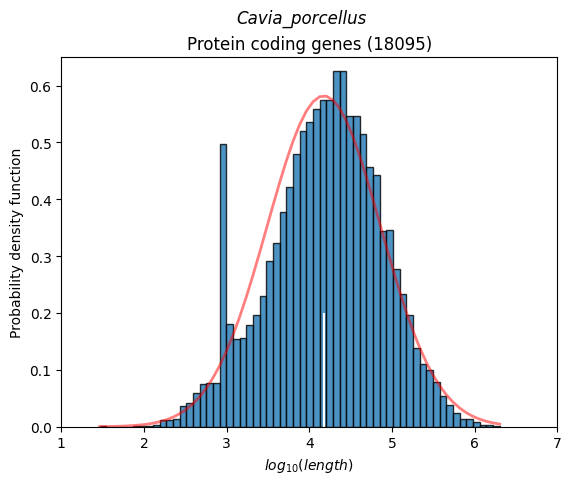

Kurtosis: -0.27267797775275016
Skewness: -0.21905949768800043
D'Agostino's K-squared test(statistics=216.8373902747619, p-value=8.210298872993568e-48)


In [10]:
tax_id = 10141
ylim = [0., 0.65]; bool_ylim = True

# plot the dist
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id, ylim, bool_ylim)

### Get genes of species 

In [96]:
# Get genes of species 
my_species =  "cavia_porcellus"
cond = stat_taxid_df["species"] == my_species
sp_df = stat_taxid_df.loc[cond]
genes_f = LENofGENES_BASE_PATH + sp_df["trunk_genes_path"].values[0] + sp_df["genes_file"].values[0]
genes_df = pd.read_csv(genes_f, low_memory=False, sep="\t")
if 1:
    print("The genes are in:", genes_f, "\ngenes_df:\n", genes_df.head(2))
    print(genes_df.shape)
    print(len(genes_df['gene_id'].unique()))

The genes are in: /media/emuro/Nubya/results/geneLength/ftp.ensembl.org/pub/release-98/genes/cavia_porcellus/protein_coding.genes.cavia_porcellus.nan.ensembl.98.tsv 
genes_df:
    Unnamed: 0      contig strand     start       end         biotype  \
0           0  DS562941.1      -    700996    701025  protein_coding   
1           1  DS562871.1      -  24970644  24970718  protein_coding   

              gene_id gene_name  length  diffLength  
0  ENSCPOG00000034073       NaN      29          45  
1  ENSCPOG00000030150       NaN      74           3  
(18095, 10)
18095


### Get GO of the genes of species 

In [ ]:
### get gene Description

In [136]:
# get gene description 
gd_f = GO_PATH + "cavia_porcellus_geneDescription_mart_export.txt"
gd_df = pd.read_csv(gd_f, low_memory=False, sep="\t")
if 0:
    print(gd_df.shape)
print(gd_df.columns)

#gd_df = gd_df.drop(['Gene stable ID version', 'Transcript stable ID version', 'Gene name'], axis=1)
gd_df = gd_df.rename(columns={'Gene stable ID': 'gene_id'})
print("GD file (num of diff gene_ids:", len(gd_df['gene_id'].unique()))

genes_gd_df = pd.merge(genes_df, gd_df, how='inner', on=['gene_id'])
print(genes_gd_df.columns)
print(len(genes_gd_df['gene_id'].unique()))

if 0:
    genes_gd_df.to_csv(GO_PATH + "em_gdescription_cavia_porcellus.txt", index=False, sep="\t")

# 911-968 ... se ve que el pico est'a ahí (grep)
#cond = (genes_gd_df['length']>=911) & (genes_gd_df['length']<=968)
cond = (genes_gd_df['length']>=900) & (genes_gd_df['length']<=1000)
peak_genes_gd_df = genes_gd_df[cond]
if 0:
    peak_genes_gd_df.to_csv(GO_PATH + "em_gdescription_peak911_968_cavia_porcellus.txt", index=False, sep="\t")

Index(['Gene stable ID', 'Gene description'], dtype='object')
GD file (num of diff gene_ids: 26855
Index(['Unnamed: 0', 'contig', 'strand', 'start', 'end', 'biotype', 'gene_id',
       'gene_name', 'length', 'diffLength', 'Gene description'],
      dtype='object')
18095


## Filter

(679, 11)
(536, 11)
     Unnamed: 0      contig strand   start     end         biotype  \
668         668  DS562911.1      +  740216  741118  protein_coding   
669         669  DS562911.1      +  670724  671626  protein_coding   

                gene_id gene_name  length  diffLength  \
668  ENSCPOG00000036207       NaN     902           0   
669  ENSCPOG00000037551       NaN     902           0   

                                      Gene description  
668  free fatty acid receptor 1-like [Source:NCBI g...  
669  free fatty acid receptor 1 [Source:NCBI gene;A...  


,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33355,vertebrates,cavia_porcellus,ftp.ensembl.org/pub/release-98/genes/cavia_por...,protein_coding.genes.cavia_porcellus.nan.ensem...,18095,44419.20519,8237268311.70416,4.17595,0.46981,Guinea Pig,10141


,Unnamed: 0,contig,strand,start,end,biotype,gene_id,gene_name,length,diffLength
0,0,DS562941.1,-,700996,701025,protein_coding,ENSCPOG00000034073,NaN,29,45
1,1,DS562871.1,-,24970644,24970718,protein_coding,ENSCPOG00000030150,NaN,74,3


(17559, 10)
       Unnamed: 0      contig strand     start       end         biotype  \
0               0  DS562941.1      -    700996    701025  protein_coding   
1               1  DS562871.1      -  24970644  24970718  protein_coding   
2               2  DS562908.1      +   9886801   9886878  protein_coding   
3               3  DS562862.1      +  52561310  52561414  protein_coding   
4               4  DS562890.1      -  18049921  18050031  protein_coding   
...           ...         ...    ...       ...       ...             ...   
18090       18090  DS562856.1      +  68977066  70450829  protein_coding   
18091       18091  DS562870.1      -  16023201  17550706  protein_coding   
18092       18092  DS562865.1      -    707945   2614464  protein_coding   
18093       18093  DS562863.1      -   9963165  11934616  protein_coding   
18094       18094  DS562933.1      -   4496784   6506092  protein_coding   

                  gene_id gene_name   length  diffLength  log10_length  
0 

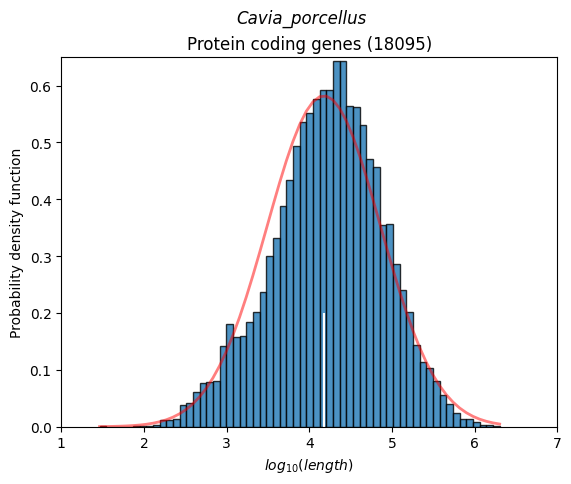

Kurtosis: -0.07430427907571602
Skewness: -0.23423906124916039
D'Agostino's K-squared test(statistics=160.73729110912748, p-value=1.248362509629563e-35)


,Unnamed: 0,contig,strand,start,end,biotype,gene_id,gene_name,length,diffLength,log10_length
0,0,DS562941.1,-,700996,701025,protein_coding,ENSCPOG00000034073,NaN,29,45,1.46240
1,1,DS562871.1,-,24970644,24970718,protein_coding,ENSCPOG00000030150,NaN,74,3,1.86923
2,2,DS562908.1,+,9886801,9886878,protein_coding,ENSCPOG00000033935,NaN,77,3,1.88649
3,3,DS562862.1,+,52561310,52561414,protein_coding,ENSCPOG00000033304,NaN,104,6,2.01703
4,4,DS562890.1,-,18049921,18050031,protein_coding,ENSCPOG00000025148,NaN,110,6,2.04139
...,...,...,...,...,...,...,...,...,...,...,...
18090,18090,DS562856.1,+,68977066,70450829,protein_coding,ENSCPOG00000015501,CSMD1,1473763,6746,6.16843
18091,18091,DS562870.1,-,16023201,17550706,protein_coding,ENSCPOG00000013332,CTNNA3,1527505,53742,6.18398
18092,18092,DS562865.1,-,707945,2614464,protein_coding,ENSCPOG00000001691,CNTNAP2,1906519,64932,6.28024
18093,18093,DS562863.1,-,9963165,11934616,protein_coding,ENSCPOG00000032459,MACROD2,1971451,37857,6.29479


In [137]:
print(peak_genes_gd_df.shape)
cond = (peak_genes_gd_df['Gene description'].str.contains('olfactory receptor', case=False)) 
cond = cond | (peak_genes_gd_df['Gene description'].str.contains('taste 2 receptor', case=False)) 
cont = cond | (peak_genes_gd_df['Gene description'].str.contains('vomeronasal 1 receptor', case=False)) 
cond = cond | (peak_genes_gd_df['Gene description'].str.contains('taste receptor', case=False))  
cond = cond | (peak_genes_gd_df['Gene description'].str.contains('receptor', case=False))  

peak_genes_gd_df = peak_genes_gd_df[cond]
print(peak_genes_gd_df.shape)
print(peak_genes_gd_df.head(2))
g_l = peak_genes_gd_df['gene_id'].to_list()


tax_id = 10141
ylim = [0., 0.65]; bool_ylim = True
new2_species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id, ylim, bool_ylim, g_l)


